In [1]:
import osmium
import shapely.wkb as wkblib
import pandas as pd
import geopandas
import osmnx as ox
import matplotlib.pyplot as plt
import psutil

In [2]:
#uncomment and download data if you need it
!wget http://download.geofabrik.de/europe/sweden-latest.osm.pbf

--2023-03-14 10:49:05--  http://download.geofabrik.de/europe/sweden-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.50.43, 65.109.48.72
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.50.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657674513 (627M) [application/octet-stream]
Saving to: ‘sweden-latest.osm.pbf’

sweden-latest.osm.p 100%[===================>] 627.21M  50.5MB/s    in 11s     

2023-03-14 10:49:16 (57.6 MB/s) - ‘sweden-latest.osm.pbf’ saved [657674513/657674513]



In [3]:
#https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00

In [3]:
#this class creates
#multipolygons for all buildings. Uses "area", and I don't know
#if e.g. "way" or "relation" also could/should be used.
#Inspiration from here https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.building_count = 0
        self.buildings = []
        # A global factory that creates WKB from a osmium geometry
        self.wkbfab = osmium.geom.WKBFactory()

    def area(self, w):
        if w.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_multipolygon(w)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": w.id, "geometry": geo }

            for key, value in w.tags:
                row[key] = value

            self.buildings.append(row)
            self.building_count += 1

In [4]:
#this runs the actual loading from the file, might take a while
buildinghandler = BuildingHandler()
buildinghandler.apply_file("sweden-latest.osm.pbf", locations=True)

In [5]:
len(buildinghandler.buildings)

2023522

In [6]:
psutil.virtual_memory().percent

9.3

In [7]:
#first to a pandas dataframe and then to geopandas
df = pd.DataFrame(buildinghandler.buildings[:100000])
gdf = geopandas.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs("EPSG:4326")
gdf = ox.project_gdf(gdf)

In [49]:
#dropping all buildings that don't have level information
gdf = gdf.dropna(subset=['building:levels'])
gdf.shape

(3056, 410)

In [62]:
#taking a look at the mean levels
gdf['building:levels'].astype(float).mean()

2.919011780104712

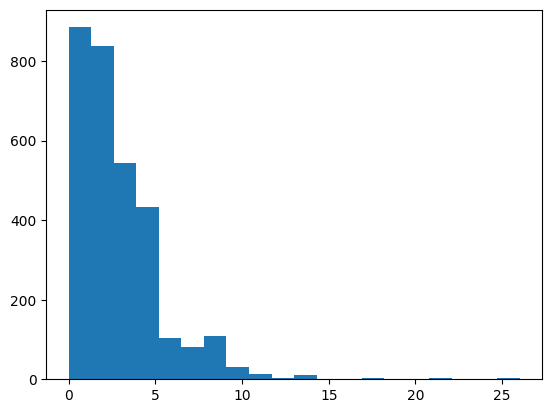

In [161]:
#taking a look at the building levels in the 100000 building sample
plt.hist(gdf['building:levels'].astype(float), bins=20)
plt.show()

In [78]:
#if one wants to store a gdf, this is how you do it
#gdf.to_file('datafram.shp')

/tmp/ipykernel_2616/2662106380.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('datafram.shp')


In [84]:
#learning new stuff about the projection
gdf.crs

<Derived Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [85]:
#testing filtering out the Stockholm region using the cx-function
#gdf_s = gdf.cx[672205:6579860, 676862:6577873]

In [8]:
i = 200000
while i < len(buildinghandler.buildings):
    dfx = pd.DataFrame(buildinghandler.buildings[(i-200000):min([i, len(buildinghandler.buildings)-1])])
    gdfx = geopandas.GeoDataFrame(dfx, geometry='geometry')
    gdfx = gdfx.set_crs("EPSG:4326")
    gdfx = ox.project_gdf(gdfx)
    gdfx = gdf.cx[672205:6579860, 676862:6577873]
    #gdfx = gdfx.dropna(subset=['building:levels'])
    gdfx = gdfx[['w_id', 'geometry', 'building:levels']]
    if i < 200001:
        meta = gdfx
    else:
        meta = pd.concat([meta, gdfx])
    print(meta.shape)
    i += 200000

(943, 3)
(1886, 3)
(2829, 3)
(3772, 3)
(4715, 3)
(5658, 3)
(6601, 3)
(7544, 3)
(8487, 3)
(9430, 3)


In [9]:
levels = meta.dropna(subset=['building:levels'])
levels.shape

(810, 3)

In [11]:
nolevel = meta.loc[~meta.index.isin(meta.dropna(subset=['building:levels']).index)]
nolevel.shape

(8620, 3)

In [12]:
y = levels['building:levels'].astype(float)
x = levels.area

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(
    x, y, train_size=600, random_state=42, shuffle=True
)

In [15]:
from sklearn.linear_model import LinearRegression

In [17]:
model = LinearRegression()

In [21]:
import numpy as np
model.fit(np.array(X_train).reshape(-1,1), y_train)

LinearRegression()

In [24]:
from sklearn.metrics import mean_squared_error
import math
predict_y = model.predict(np.array(X_test).reshape(-1,1))
rmse = math.sqrt(mean_squared_error(y_test,predict_y))
rmse

2.3005366666306863

In [26]:
#computing scatter indexs
rmse / y.mean() * 100
#and it is very high - the model is not a good one

72.64852631465327

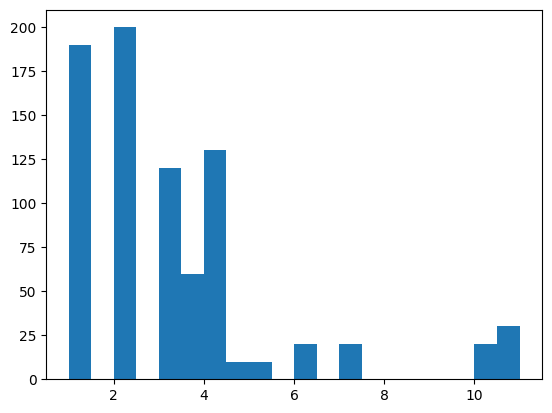

In [29]:
plt.hist(y, bins=20)
plt.show()

Text(0.5, 0, 'area at groundlevel')

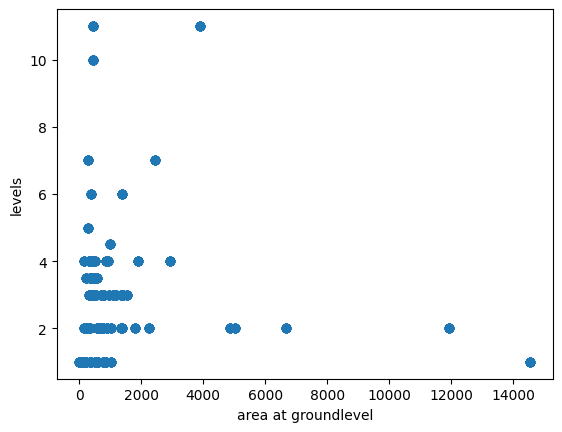

In [34]:
plt.scatter(x, y)
plt.ylabel('levels')
plt.xlabel('area at groundlevel')

In [35]:
y.mean()

3.1666666666666665

In [36]:
nolevel['building:levels'] = 3.167

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
nolevel['building:levels']

45       3.167
46       3.167
113      3.167
278      3.167
668      3.167
         ...  
98941    3.167
98942    3.167
98949    3.167
98950    3.167
98951    3.167
Name: building:levels, Length: 8620, dtype: float64

In [38]:
nolevel['randomlevel'] = 'yes'

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [39]:
levels['randomlevel'] = 'no'

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [40]:
soder = pd.concat([nolevel, levels])
soder

,w_id,geometry,building:levels,randomlevel
45,18713762,"MULTIPOLYGON (((696333.120 6392680.068, 696400...",3.167,yes
46,18714514,"MULTIPOLYGON (((698764.740 6391980.459, 698832...",3.167,yes
113,29752260,"MULTIPOLYGON (((672267.605 6576424.625, 672272...",3.167,yes
278,45929720,"MULTIPOLYGON (((674988.771 6573155.966, 675052...",3.167,yes
668,47035202,"MULTIPOLYGON (((674653.143 6572307.140, 674655...",3.167,yes
...,...,...,...,...
61137,180757626,"MULTIPOLYGON (((676862.921 6574335.512, 676871...",1,no
62040,180891850,"MULTIPOLYGON (((677184.881 6570131.155, 677195...",2,no
62043,180891868,"MULTIPOLYGON (((677183.114 6569952.822, 677187...",1,no
62046,180891876,"MULTIPOLYGON (((677090.251 6569959.434, 677103...",1,no


In [41]:
soder['floorarea'] = soder.area * soder['building:levels'].astype(float)
#metal = metal[meta['building:levels'].str.contains('[A-Za-z]') == False]

In [42]:
soder['floorarea']

45        7472.331497
46       10816.076112
113      16026.841148
278      21668.615210
668       1052.932553
             ...     
61137      504.972199
62040      285.919652
62043      184.621453
62046      112.947263
73236      206.724128
Name: floorarea, Length: 9430, dtype: float64

In [43]:
#multiplying floor area with figure from Antti's model, using climate zone 5 for Stockholm
soder['kWh/a'] = soder['floorarea'] * 159.993

In [44]:
#using this article https://www.sei.org/publications/swedish-heat-energy-system-new-tensions-and-lock-ins-after-a-successful-transition/#:~:text=Fossil%20fuel%20energy%20has%20been,demand%20for%20heating%20in%20buildings.
#to calculate an estimate of the energy mix and it's co2-emissions using Antti's model
co2 = 0.5*0.195 + 0.25*0.104 + 0.08*0.255 + 0.08*0.354 + 0.09*0.403
co2

0.20848999999999998

In [45]:
#multiplying kWh with co2/kWh for estimate of co2-emissions
soder['yearly-co2'] = soder['kWh/a'] * co2

In [49]:
soder = soder.rename(columns={'building:levels':'levels', 'yearly-co2':'co2/a', 'randomlevel':'fakelevel'})

In [50]:
soder.head()

,w_id,geometry,levels,fakelevel,floorarea,kWh/a,co2/a
45,18713762,"MULTIPOLYGON (((696333.120 6392680.068, 696400...",3.167,yes,7472.331497,1.195521e+06,249254.117651
46,18714514,"MULTIPOLYGON (((698764.740 6391980.459, 698832...",3.167,yes,10816.076112,1.730496e+06,360791.208065
113,29752260,"MULTIPOLYGON (((672267.605 6576424.625, 672272...",3.167,yes,16026.841148,2.564182e+06,534606.387701
278,45929720,"MULTIPOLYGON (((674988.771 6573155.966, 675052...",3.167,yes,21668.615210,3.466827e+06,722798.709787
668,47035202,"MULTIPOLYGON (((674653.143 6572307.140, 674655...",3.167,yes,1052.932553,1.684618e+05,35122.608598


In [51]:
soder.to_file('sodermalm-all.shp')

In [29]:
how_to_read = geopandas.read_file('sodermalm.shp')
how_to_read.head()

,w_id,levels,floorarea,kWh/a,co2/a,geometry
0,29741604,4,11743.984416,1.878955e+06,391743.390228,"POLYGON ((675282.055 6577525.008, 675301.606 6..."
1,29752940,4,2031.588532,3.250399e+05,67767.577923,"POLYGON ((672911.430 6576548.124, 672922.732 6..."
2,47971704,2,4490.550194,7.184566e+05,149791.015938,"POLYGON ((678820.355 6571576.675, 678839.388 6..."
3,48029436,2,672.347392,1.075709e+05,22427.451988,"POLYGON ((679299.694 6574068.135, 679308.462 6..."
4,48780448,1,14555.442774,2.328769e+06,485525.039569,"POLYGON ((673941.779 6572849.976, 674217.168 6..."
